<h1>
Experimenting on Maryland's Electoral Boundaries Using Modified Versions of K-Means Clustering Algorithm - Jeffrey Lyngdoh
</h1>



1.   Introduction and Background
2.   Measure of Sucess
3.   The Data
4.   Format and Functions
5.   Basic K Means Clustering
6.   Distance Penality
8.   Disperse Assignment
9.   Conclusions, Thoughts, Improvements

<h2>Introduction</h2>

While completing a machine learning course, I wanted to implement some algorithms I'd learned. K-means clustering struck me as an interesting and tangible, unsupervised learning model. I aimed to observe its effects on population density and noticed its potential for drawing boundaries. Maryland, my state, has a history of gerrymandering, where electoral boundaries are drawn irregularly to favor certain populations. I wondered if K-means clustering could address this issue by using population size and locations to draw logical, fair election boundaries.







<h2> Background </h2>

<p>
Electoral districts are geographic areas with defined boundaries that each elect a single representative to a legislative body. The size and population of these districts can vary widely, but they are typically designed to ensure roughly equal population sizes to provide fair representation.
</p>

<p>
Gerrymandering is the practice of manipulating the boundaries of electoral districts to favor a particular political party or group. This can involve "packing" (concentrating opposing voters into a few districts) or "cracking" (diluting the voting power of the opposition across many districts). By altering the size and population distribution of districts, gerrymandering can undermine fair representation and skew election outcomes.
</p>

More Information here:
<a>https://www.youtube.com/watch?v=MnhFm5QVVTo&ab_channel=CrashCourse</a>

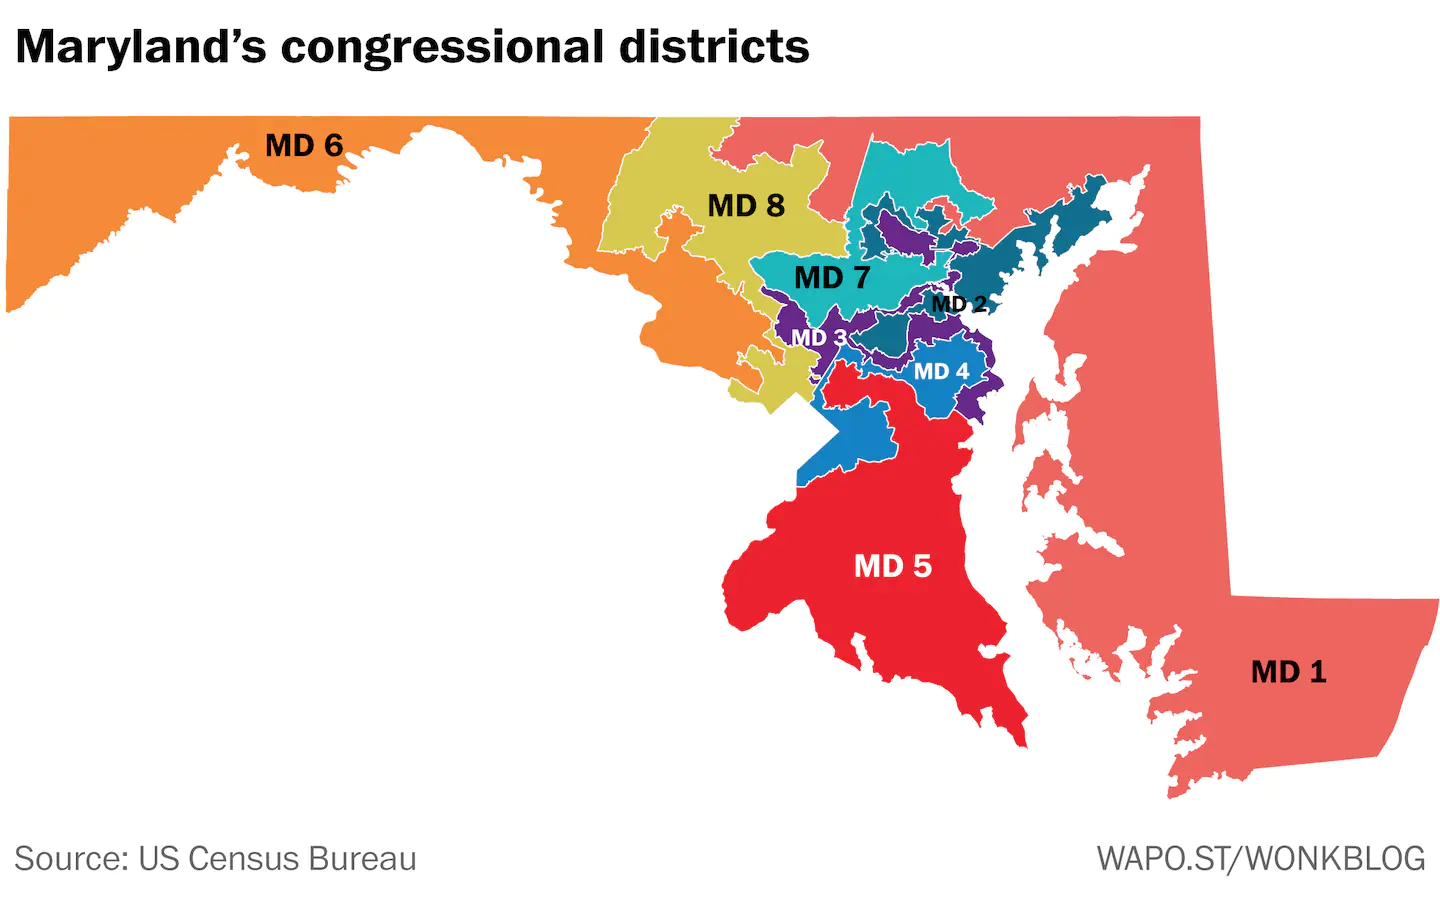

Maryland's electoral districts used to look like this. Notice the strange shapes of several districts, particularly how District 4 protrudes into District 5. This boundary is designed to incorporate rural voters into more urban areas, affecting the overall political representation.







Maryland has a population of approximately 6 million, a single electoral district is composed of about 760,000 people thus we are aiming to establish about 8 districts of such size. Keeping these districts concise and approximately equal will be the main challenge. Each of my implementations come with their own pros and cons.


<h2>Measure of Sucess</h2>

<p>
The goal of these clustering algorithms is to establish well-defined electoral districts using data points that represent population groups in Maryland.
</p>

<p>
Deciding what constitutes "well-defined" electoral districts can be somewhat subjective. Here are a few characteristics we are aiming for:
</p>

*   Population Equality: Each district should have a roughly equal number of residents.

*   Separation of Population Density: Districts should separate densely populated areas from sparsely populated ones.

*   Orderly and Predictable Boundaries: The boundaries of the districts should be clearly and logically defined.


Measuring how well we achieve this goal is challenging because our approach is unsupervised and lacks a precise mathematical formula for error measurement. Instead, we must rely on intuition and observation to evaluate success. Throughout my project, I will implement various strategies and examine the benefits and drawbacks of each.



<h1>The Data</h1>

Collecting population data along with corresponding locations was challenging. The Census provides useful information, but combining and collecting it was tricky.

I was able to gather census block data from Maryland's GIS Data Catalog: <br>
https://data.imap.maryland.gov/datasets/maryland::maryland-census-boundaries-census-block-groups-2020/about

According to the catalog: “Census Blocks are statistical areas bounded on all sides by visible features, such as streets, roads, streams, and railroad tracks, and/or by non-visible boundaries such as city, town, township, and county limits, and short line-of-sight extensions of streets and roads.” Essentially, census blocks are small units of land area and population, combined to form electoral districts.

The dataset provides a table of each census block within Maryland, including its location, size, and shape information. However, it lacks exact population figures for each block, stating: “Census 2020 BGs generally contained between 600 and 3,000 people, with an optimum size of 1,500 people.” This means each table entry represents an area with about 1,500 people. Having exact population data for each block would improve boundary accuracy, but this estimation simplifies the process.

While it is possible to combine this data with other tables in the catalog, doing so often results in considerable data loss. I acknowledge my data collection and estimations may be imperfect, which could be a point for future improvement.

The catalog does offer APIs, but I found them to be unreliable and slow. Therefore, I opted to download the CSV file and manually upload it, then convert it into a dataframe for analysis.


https://data.imap.maryland.gov/datasets/maryland::maryland-census-boundaries-census-block-groups-2020/explore?location=38.775684%2C-77.268400%2C7.38&showTable=true


In [ ]:
from google.colab import files
import io

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

To run simply upload the provided CSV file which you can download from repository

In [ ]:
census = files.upload()
# Access the first (and presumably only) uploaded file
file_key = list(census.keys())[0]
census_data = pd.read_csv(io.BytesIO(census[file_key]))


Saving Maryland_Census_Boundaries_-_Census_Block_Groups_2020.csv to Maryland_Census_Boundaries_-_Census_Block_Groups_2020.csv


In [ ]:
census_data

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,ShapeSTArea,ShapeSTLength
0,4080,24,31,700903,1,240317009031,Block Group 1,G5030,S,3837935,18627,39.096400,-77.127803,6.411367e+06,11506.170632
1,4081,24,31,701101,4,240317011014,Block Group 4,G5030,S,431071,0,39.079877,-77.122418,7.163619e+05,5237.416264
2,4082,24,33,803508,2,240338035082,Block Group 2,G5030,S,930573,0,38.927943,-76.866570,1.539851e+06,5380.809583
3,4083,24,33,803508,3,240338035083,Block Group 3,G5030,S,273692,0,38.922573,-76.861478,4.528223e+05,3336.653430
4,4084,24,33,803509,1,240338035091,Block Group 1,G5030,S,1091937,3091,38.932261,-76.877008,1.812192e+06,6117.460494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074,8154,24,21,751906,1,240217519061,Block Group 1,G5030,S,1552991,0,39.388527,-77.291756,2.603546e+06,9918.206423
4075,8155,24,21,752206,2,240217522062,Block Group 2,G5030,S,677264,0,39.329629,-77.350572,1.133446e+06,5922.041993
4076,8156,24,21,750507,1,240217505071,Block Group 1,G5030,S,783143,0,39.427778,-77.468729,1.314304e+06,5762.834503
4077,8157,24,21,750507,2,240217505072,Block Group 2,G5030,S,245427,0,39.426705,-77.462392,4.118752e+05,2890.383629


As we can observe, there are 4079 rows in the dataset, with each row representing approximately 1500 people. The dataset contains numerous features, which you can explore further using the link below. However, for clustering purposes, we only need location attributes, specifically longitude and latitude.

https://geodata.md.gov/imap/rest/services/Demographics/MD_CensusBoundaries/MapServer/1



<h1>
Format and Functions
</h1>

We aim to organize a list of geographic coordinates (representing census blocks) into clusters (districts) and keep track of which data points belong to each cluster, as well as the center of each cluster.

Our approach will take a list of coordinates (along with any other needed parameters) and return two 2D arrays:

1.   A list containing NumPy arrays for each district, where each NumPy array holds the coordinates assigned to that district.
2.   A list containing the center (mean coordinate) of each district.

Input a list of coordinates in the form:
```
Input: [(latitude, longitude), (latitude, longitude), (latitude, longitude), (latitude, longitude)]

```

Output a 2d array repersenting each district and a 2d array repersenting their respective centers:



```
clusters = [
    np.array([(latitude, longitude), (latitude, longitude), ...]),  # district 1
    np.array([(latitude, longitude), (latitude, longitude), ...]),  # district 2
    np.array([(latitude, longitude), (latitude, longitude), ...]),  # district 3
    ...
]

centers = np.array([
    (latitude, longitude),  # district 1 mean
    (latitude, longitude),  # district 2 mean
    (latitude, longitude),  # district 3 mean
    ...
])
```

Clusters:
Each district in the clusters list is a NumPy array containing the coordinates assigned to it.
Since NumPy arrays in a 2D array need to have the same dimensions and our clusters will not have the same number of points, we use a Python list to hold these NumPy arrays.

Centers:
Each element in the centers list is a tuple representing the mean coordinate (latitude, longitude) of the respective district.
These tuples are simple (latitude, longitude) pairs representing the center of each district.

Note:
Interior arrays such as district_1, district_2, etc will be numpy arrays.The outer array containing them will be a normal python list as 2d numpy arrays are required to be the same dimension which our clusters will not be.


Example


```
Suppose we have the following input coordinates:

  coordinates = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]

After clustering, we might have:

  clusters = [
      np.array([(1, 2), (3, 4)]),      # district 1
      np.array([(5, 6), (7, 8)]),      # district 2
      np.array([(9, 10)])              # district 3
  ]

  centers = np.array([
    (2.0, 3.0),  # Mean of district 1
    (6.0, 7.0),  # Mean of district 2
    (9.0, 10.0)  # Mean of district 3
  ])
```

This structure ensures that each district's coordinates and its mean center are clearly organized and accessible.






We can define a function which takes in resulting clusters and centers of the above format plot them. This will allow us observe the resulting districts visually.


In [ ]:
# The clusters variable is a list of numpy arrays, where each array represents a district and contains tuples of (latitude, longitude)
# Example:
# clusters = [
#     np.array([(latitude, longitude), (latitude, longitude), ...]),  # district 1
#     np.array([(latitude, longitude), (latitude, longitude), ...]),  # district 2
#     np.array([(latitude, longitude), (latitude, longitude), ...]),  # district 3
#     ...
# ]

# The centers variable is a numpy array containing tuples of (latitude, longitude) for each district's center
# Example:
# centers = np.array([
#     (latitude, longitude),  # district 1 mean
#     (latitude, longitude),  # district 2 mean
#     (latitude, longitude),  # district 3 mean
#     ...
# ])

# Given clusters and centers in the format above, this function extracts the data points from each district and plots them onto a scatter plot.
# Plotting the centers is optional.

def plotting_map(clusters, centers=[]):

  # Start by iterating through each cluster along with its index.
  # Each cluster should be a numpy array containing tuples of (latitude, longitude).
  for index, cluster in enumerate(clusters):

    # Separate the first and second columns using numpy slicing to obtain arrays of latitude and longitude.
    latitude = cluster[:, 0]
    longitude = cluster[:, 1]

    # Plot these coordinates on a scatter plot with a label corresponding to the district index. Set opacity to 0.3.
    plt.scatter(longitude, latitude, label=f'District {index + 1}', alpha=0.3)

  # If centers are provided, plot them as well. Use a black 'X' marker to make them stand out.
  if len(centers) > 0:
    plt.scatter(centers[:, 1], centers[:, 0], label='Centers', color='black', marker='X')

  # Add labels to the axes, a title to the plot, and display the legend. Finally, show the resulting plot.
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title('Generated Electoral Boundary')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()

Testing this out with only the coordinates as centers we can observe the approxmiate shape of maryland.


In [ ]:
# Combine latitude and longitude into a coordinate list of tuples, which will be useful later
coordinates = np.array([(x, y) for x, y in zip(census_data['INTPTLAT20'], census_data['INTPTLON20'])])


We can test our function by passing all coordinates as one large district and the center point of Maryland. The result is an approximate map of Maryland with a clearly defined center point.

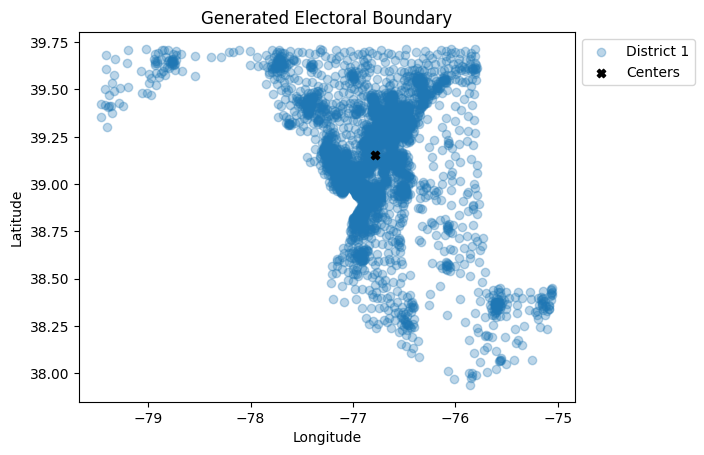

In [ ]:
plotting_map([coordinates], np.array([(np.mean(coordinates[:, 0]), np.mean(coordinates[:, 1]))]))


<h1> Basic K Means Clustering </h1>


Let's start off implementing the most basic form of K-Means Clustering
---
Choose the number of clusters (K):
* Decide the number of clusters you want to divide your data into.

Initialize centroids:
* Randomly select K data points from the dataset as the initial centroids (cluster centers).

Assign points to the nearest centroid:
* For each data point, calculate the distance (usually Euclidean distance) to each centroid. Assign the data point to the cluster whose centroid is the nearest.

Update centroids:
* For each cluster, calculate the new centroid by taking the mean of all data points assigned to that cluster.
The new centroid is the average of the positions of all the points in the cluster.

Repeat steps 3 and 4:
* Repeat the assignment and update steps until the centroids no longer change significantly, or a maximum number of iterations is reached. This indicates that the clusters are stable and the algorithm has converged.


We can implement this in code, passing our coordinates, k (number of clusters) and a cap on the number of iterations to make sure we can stop.

We start by establishing a distance metric in this case Euclidean distance between the latitudes and longitudes of each point.

Using this we can assign data points to each corresponding center based on how far they are.

After that we can update our centers, making sure we maintain our format above.


In [ ]:
def square_distance(p1, p2):
    """
    Compute the squared Euclidean distance between two points.

    Parameters:
    p1 (tuple): First point coordinates (x1, x2).
    p2 (tuple): Second point coordinates (y1, y2).

    Returns:
    float: Squared Euclidean distance between p1 and p2.
    """
    # Unpack the coordinates of the points
    x1, x2 = p1
    y1, y2 = p2

    # Compute and return the squared Euclidean distance
    return (x1 - y1) ** 2 + (x2 - y2) ** 2

def assign_datapoints(coordinates, centers, k):
    """
    Assign each data point to the nearest cluster center.

    Parameters:
    coordinates (numpy.ndarray): Array of data points.
    centers (numpy.ndarray): Array of cluster centers.
    k (int): Number of clusters.

    Returns:
    list of numpy.ndarray: List of clusters, each containing data points assigned to it.
    """
    # Initialize list to hold clusters
    result = [[] for _ in range(k)]

    # Assign each point to the nearest cluster center
    for point in coordinates:
        distances = np.array([square_distance(point, center) for center in centers]) # returns list of distance between point and each center
        idx = np.argmin(distances) # get index of smallest cooresponding distance
        result[idx].append(point) # add point to cluster of cooresponding center

    # Convert lists to numpy arrays
    result = [np.array(cluster) for cluster in result]

    return result

def update_centers(clusters):
    """
    Update the cluster centers based on the mean of points in each cluster.

    Parameters:
    clusters (list of numpy.ndarray): List of clusters, each containing data points.

    Returns:
    numpy.ndarray: Array of updated cluster centers.
    """
    result = []

    # Compute the mean of points in each cluster
    for cluster in clusters:
        lat_mean = np.mean(cluster[:, 0])  # Mean of latitude values
        long_mean = np.mean(cluster[:, 1])  # Mean of longitude values
        result.append([lat_mean, long_mean])

    return np.array(result)

def k_means_clustering(coordinates, k, max_iterations):
    """
    Perform K-means clustering on the given data points.

    Parameters:
    coordinates (numpy.ndarray): Array of data points.
    k (int): Number of clusters.
    max_iterations (int): Maximum number of iterations for convergence.

    Returns:
    tuple: Tuple containing clusters and their centers.
    """
    # Randomly initialize cluster centers
    centers = coordinates[random.sample(range(len(coordinates)), k)]

    # Assign data points to clusters and update centers iteratively until convergence
    for _ in range(max_iterations):
        # Assign data points to clusters
        clusters = assign_datapoints(coordinates, centers, k)

        # Update cluster centers
        new_centers = update_centers(clusters)

        # Check for convergence
        if np.array_equal(new_centers, centers):
            break

        # Update centers for the next iteration
        centers = new_centers

    return clusters, centers


Assuming our data points represent a population of 1500 our data has a total population of 6118500. The actual population of Maryland in 2020 is about 6.056 million so this is a reasonable guess.


In [ ]:
population_estimate = len(census_data) * 1500
print(population_estimate)

6118500


Based on this population we can estimate how many districts we are aiming for in this case 8.


In [ ]:
number_dist = population_estimate // 760000
print(number_dist)

8


We can now test out our implementation with the coordinates, number of districts, and a cap of 100 iterations.


In [ ]:
general_clusters, general_centers = k_means_clustering(coordinates, number_dist, 100)

We can plot our results below


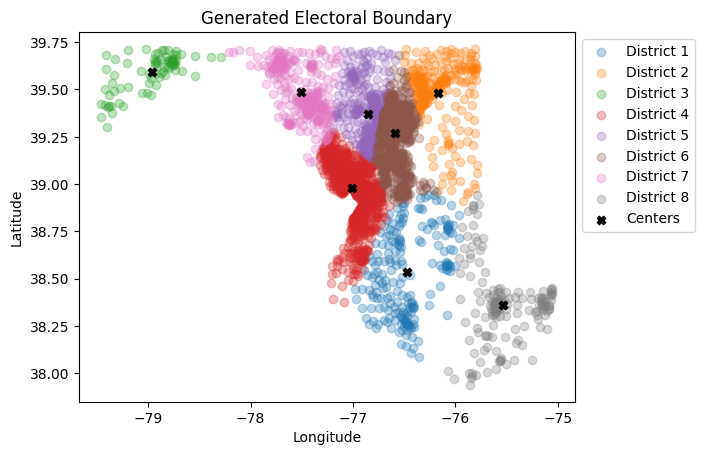

In [ ]:
plotting_map(general_clusters, general_centers)

After examining the electoral boundaries we've derived, we notice a distinct pattern of organization and tidiness. However, upon closer inspection, we identify a concern: certain clusters appear noticeably denser than others.

To investigate further, we decide to assess the estimated population of each district. Upon doing so, we observe a discrepancy in population distribution a high degree of variance between each data point. Some districts are found to be overpopulated, while others are underpopulated. This population mismatch warrants attention and further consideration in our electoral planning.



In [ ]:
def population_estimator(clusters):
    """
    Estimate the population of each district based on the number of points in each cluster.

    Parameters:
    clusters (list of numpy.ndarray): List of clusters, each containing data points.

    Returns:
    None
    """
    district_populations = []

    # Iterate over each cluster and estimate population
    for index, cluster in enumerate(clusters):
        district_population = len(cluster)
        print(f'Population of district {index + 1}: {district_population * 1500}')
        district_populations.append(district_population)

    # Calculate total population
    total_population = sum(district_populations)

    # Calculate mean population
    mean_population = total_population / len(clusters)

    # Calculate variance based on the number of data points
    variance_population = sum((population - mean_population) ** 2 for population in district_populations) / len(clusters)

    # Print total population and variance
    print(f'Total population: {total_population * 1500}')
    print(f'Scaled population variance: {variance_population}')

In [ ]:
population_estimator(general_clusters)

Population of district 1: 300000
Population of district 2: 418500
Population of district 3: 117000
Population of district 4: 1927500
Population of district 5: 619500
Population of district 6: 1995000
Population of district 7: 480000
Population of district 8: 261000
Total population: 6118500
Scaled population variance: 220939.359375


<h1> Distance Penalty </h1>

We ask ourselves how we can modify K means clustering in a way that keeps our populations uniform.

One potenial approach is to adjust the algorithm to preferentially assign data points to smaller clusters. This can be done by applying a penalty to larger clusters.

Since data points are typically assigned to clusters based on distance, we can implement a new distance function that also considers the size of the clusters.

This approach is not exact and can be implemented in various ways. To keep things simple, my implementation will define an upper size boundary for clusters and apply a ratio to the distance based on how full each cluster is.


In [ ]:
def distance_with_pen(p1, p2, ratio, reg):
  """
  Compute the penalized squared Euclidean distance between two points.

  Parameters:
  p1 (tuple): First point coordinates (x1, x2).
  p2 (tuple): Second point coordinates (y1, y2).
  ratio (float): Ratio of the number of points in the current cluster to the average cluster size.
  reg (int): Regularization exponent.

  Returns:
  float: Penalized squared Euclidean distance between p1 and p2.
  """
  # Unpack the coordinates of the points
  x1, x2 = p1
  y1, y2 = p2

  # Compute the squared Euclidean distance
  distance = (x1 - y1) ** 2 + (x2 - y2) ** 2

  # Add penalty based on the ratio and regularization factor
  return distance * (ratio ** reg)

def assign_datapoints_penalty(coordinates, centers, k):
  """
  Assign each data point to the nearest cluster center, applying a penalty based on cluster size.

  Parameters:
  coordinates (numpy.ndarray): Array of data points.
  centers (numpy.ndarray): Array of cluster centers.
  k (int): Number of clusters.

  Returns:
  list of numpy.ndarray: List of clusters, each containing data points assigned to it.
  """
  # Initialize list to hold clusters
  result = [[] for _ in range(k)]

  # Calculate average cluster size
  size = (len(coordinates) / k)

  # Assign each point to the nearest cluster center
  for point in coordinates:
    # Compute the penalized distance between the point and each center
    reg = 3
    distances = np.array([distance_with_pen(point, center, len(cluster) / size, reg) for center, cluster in zip(centers, result)])
    idx = np.argmin(distances)  # Get index of the smallest corresponding distance
    result[idx].append(point)  # Add point to the cluster of the corresponding center

  # Convert lists to numpy arrays
  result = [np.array(cluster) for cluster in result]

  return result

def update_centers_penalty(clusters):
  """
  Update the cluster centers based on the mean of points in each cluster.

  Parameters:
  clusters (list of numpy.ndarray): List of clusters, each containing data points.

  Returns:
  numpy.ndarray: Array of updated cluster centers.
  """
  result = []

  # Compute the mean of points in each cluster
  for cluster in clusters:
    lat_mean = np.mean(cluster[:, 0])  # Mean of latitude values
    long_mean = np.mean(cluster[:, 1])  # Mean of longitude values
    result.append([lat_mean, long_mean])

  return np.array(result)

def k_means_clustering_penalty(coordinates, k, max_iterations):
  """
  Perform K-means clustering with penalty on the given data points.

  Parameters:
  coordinates (numpy.ndarray): Array of data points.
  k (int): Number of clusters.
  max_iterations (int): Maximum number of iterations for convergence.

  Returns:
  tuple: Tuple containing clusters and their centers.
  """
  # Randomly initialize cluster centers
  centers = coordinates[random.sample(range(len(coordinates)), k)]

  # Assign data points to clusters and update centers iteratively until convergence
  for i in range(max_iterations):

    # Shuffling our coordinates to keep things uniform
    shuffled_indices = np.random.permutation(len(coordinates))
    coordinates = coordinates[shuffled_indices]

    # Assign data points to clusters
    clusters = assign_datapoints_penalty(coordinates, centers, k)

    # Update cluster centers
    new_centers = update_centers_penalty(clusters)

    # Check for convergence
    if np.array_equal(new_centers, centers):
        break

    # Update centers for the next iteration
    centers = new_centers

  return clusters, centers

This implementation builds on the basic k-means clustering algorithm with an important modification: we adjust the distance calculation to account for the current size of each cluster. Here's how it works:

Adjusted Distance Function:

* We modify the distance function to factor in the number of data points already assigned to the cluster.

Ideal Cluster Size:
* We define an ideal size for each cluster, calculated as the total number of data points divided by the number of clusters. This represents the target size each cluster should ideally have.

Ratio Calculation:
* As we assign each point to a cluster, we calculate a ratio representing how close the current cluster size is to the ideal size. If the cluster has more points than the ideal size, the ratio will be greater than 1; if it has fewer points, the ratio will be less than 1.

Regularization:
* The ratio is raised to the power of a regulator (in this case, 2). This exponentiation emphasizes the deviation from the ideal size, compounding the effect of the ratio.

Penalized Distance:
* The original distance between a point and a cluster center is then multiplied by this adjusted ratio. If the cluster is larger than the ideal size, the distance increases, discouraging further assignment to that cluster. Conversely, if the cluster is smaller, the distance decreases, encouraging more points to be assigned to it.

This approach helps to balance the clusters more evenly by dynamically adjusting the attractiveness of each cluster based on its current size. Let's implement this and observe the results.



In [ ]:
penalty_clusters, penalty_centers = k_means_clustering_penalty(coordinates, number_dist, 500)


In [ ]:
population_estimator(penalty_clusters)

Population of district 1: 514500
Population of district 2: 964500
Population of district 3: 1059000
Population of district 4: 745500
Population of district 5: 637500
Population of district 6: 775500
Population of district 7: 840000
Population of district 8: 582000
Total population: 6118500
Scaled population variance: 13602.609375


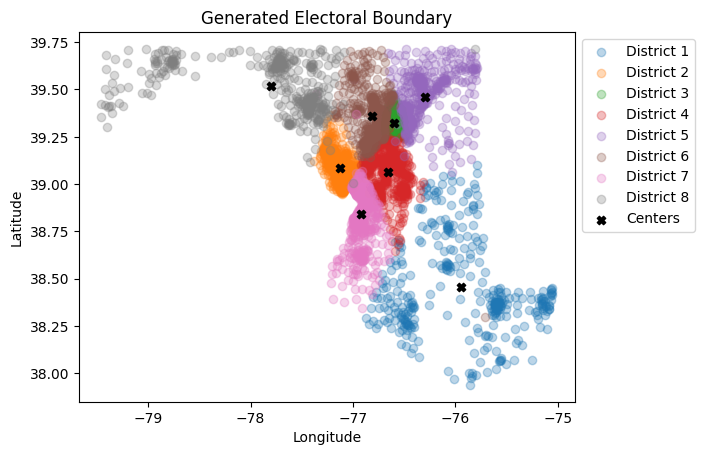

In [ ]:
plotting_map(penalty_clusters, penalty_centers)

The results reveal several interesting trends. Firstly, the populations across districts are more uniform, exhibiting a lower average variance. Although there are still some districts that are over or under-populated, the differences are smaller.

The generated map shows well-divided districts with a decent representation of population density. However, there are a few outlier points: data points assigned to distant clusters or surrounded by points from other clusters. Addressing these issues would require a reclassification function to clean up the data. This could involve reassigning data points based on their neighbors.


To manage varying cluster sizes, we need a method for redistributing data points. For an underpopulated cluster, we must find a way to transfer data points from an overpopulated one. If the two clusters are adjacent, this can be straightforward. If there is a cluster of ideal size between them, we might need to establish a system for exchanging data points, using the middle cluster as an intermediary. Determining if clusters border each other can be complex.


The primary focus of this project is clustering, so writing such a function is not within the current scope. However, this project is open-ended, and I may revisit this idea in the future. Additionally, modifying the number of iterations and the penalty distance function could potentially yield better results.


<h1>Disperse Assignment</h1>

Playing with distance can indeed make clusters more uniform, but oversized or undersized clusters can still occur. Instead, we could enforce a strict limit on cluster sizes by stopping growth once a cluster reaches its ideal size.

The basic idea is as follows: Given the ideal size of each cluster and their respective centers, we iterate through each data point and determine the closest center. We then attempt to add the data point to the corresponding cluster. If the cluster has space, we simply add the data point. If the cluster is full, we check if the new point is closer to the cluster center than any existing point in the cluster. If it is, we replace the furthest point with the new point and reassign the removed point. If the cluster is full and no replacement is possible, we attempt to assign the data point to the next closest center.

This approach ensures that clusters do not exceed their ideal sizes while attempting to keep data points as close as possible to their respective centers. This method should result in more uniform clusters and better representation of population density.


In [ ]:
def replace_datapoint(cluster, center, point):
    """
    Replaces the farthest point in the cluster with the new point if it's closer to the center.

    Parameters:
    cluster (numpy array): Current cluster of points.
    center (tuple): Center of the cluster.
    point (tuple): New point to consider for inclusion.

    Returns:
    tuple: The point that was replaced and the updated cluster.
    """
    cluster = insert_cluster_sorted(center, cluster, point)
    replace_point = cluster.pop()  # Remove the farthest point
    return replace_point, cluster

def insert_cluster_sorted(center, cluster, point):
    """
    Inserts a point into the cluster such that the cluster remains sorted based on distance to the center.

    Parameters:
    center (tuple): Center of the cluster.
    cluster (numpy array): Current cluster of points.
    point (tuple): New point to insert.

    Returns:
    numpy array: Updated cluster with the new point inserted.
    """
    result = []
    point_distance = square_distance(point, center)  # Distance of the new point to the center

    inserted = False

    for entry in cluster:
        entry_distance = square_distance(entry, center)  # Distance of the current entry to the center

        # Insert the new point if its distance is less than the current entry's distance
        if not inserted and point_distance < entry_distance:
            result.append(point)
            inserted = True
            result.append(entry)
        else:
            result.append(entry)

    # If the new point was not inserted, append it at the end
    if not inserted:
        result.append(point)

    return result

def assign_datapoints_even(coordinates, centers, k):
    """
    Assigns datapoints to clusters in a balanced way.

    Parameters:
    coordinates (numpy array): Data points to cluster.
    centers (numpy array): Initial centers of the clusters.
    k (int): Number of clusters.

    Returns:
    list: List of clusters with assigned datapoints.
    """
    result = [[] for _ in range(k)]
    max_size = (len(coordinates) // k) + 1  # Maximum allowed size for each cluster

    queue = coordinates.copy()
    shuffled_indices = np.random.permutation(len(queue))
    queue = queue[shuffled_indices]  # Shuffle the points to ensure random assignment

    while queue.size > 0:
        point = queue[0]
        queue = np.delete(queue, 0, axis=0)

        # Calculate distances from the point to each center
        distances = np.array([square_distance(point, center) for center in centers])
        sorted_indices = np.argsort(distances)

        for idx in sorted_indices:
            # Check if the current cluster can accommodate more points
            if len(result[idx]) < max_size:
                result[idx] = insert_cluster_sorted(centers[idx], result[idx], point)
                break
            # Replace a point if the new point is closer to the center
            elif square_distance(point, centers[idx]) < square_distance(result[idx][-1], centers[idx]):
                replace_point, new_cluster = replace_datapoint(result[idx], centers[idx], point)
                result[idx] = new_cluster
                queue = np.vstack([queue, replace_point])
                break

    result = [np.array(r) for r in result]
    return result

def k_means_clustering_even_assignment(coordinates, k, max_iterations, centers = []):
    """
    Performs k-means clustering with even assignment of datapoints to clusters.

    Parameters:
    coordinates (numpy array): Data points to cluster.
    k (int): Number of clusters.
    max_iterations (int): Maximum number of iterations.

    Returns:
    tuple: Final clusters and their centers.
    """
    if not centers:  # If no initial centers are provided, randomly initialize them

      centers = coordinates[random.sample(range(len(coordinates)), k)]  # Initialize centers randomly

    clusters = assign_datapoints_even(coordinates, centers, k)

    for i in range(max_iterations):
        print(f'Iteration: {i + 1}')

        clusters = assign_datapoints_even(coordinates, centers, k)

        new_centers = update_centers(clusters)

        # Stop if centers do not change
        if np.array_equal(new_centers, centers):
            break

        centers = new_centers

    return clusters, centers



In [ ]:
even_clusters, even_centers = k_means_clustering_even_assignment(coordinates, number_dist, 15)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


We can observe the population of each district, they are almost all the same size.

In [ ]:
population_estimator(even_clusters)

Population of district 1: 765000
Population of district 2: 763500
Population of district 3: 765000
Population of district 4: 765000
Population of district 5: 765000
Population of district 6: 765000
Population of district 7: 765000
Population of district 8: 765000
Total population: 6118500
Scaled population variance: 0.109375


Lets now observe the map

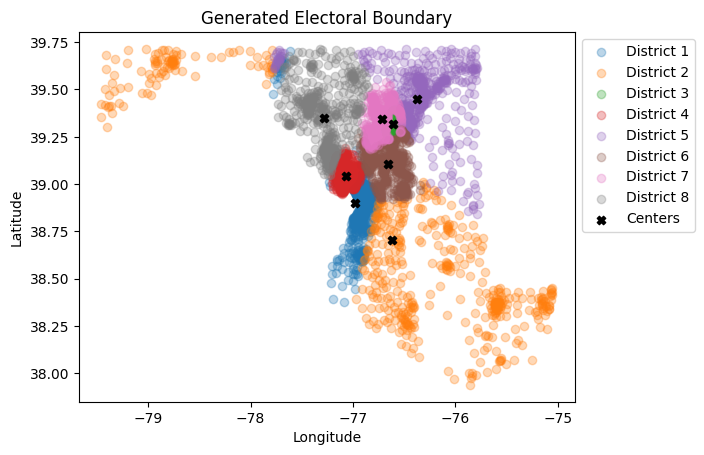

In [ ]:
plotting_map(even_clusters, even_centers)

There are a few key points to consider. First, this implementation has a significantly higher computational cost and requires more resources compared to other methods. This is why we cap the number of iterations at 15. While optimization can help, this limitation suggests that we might need to explore different approaches.

However, the resulting boundaries are quite interesting. Generally, they align with our goals of achieving uniform population distribution, separating sparsely and densely populated areas, and creating reasonably well-defined districts.

There are a few issues to note. Some data points are outliers, similar to the distance penalty problem, and some district shapes can be skewed. Interestingly, some results combined rural areas across the state into single districts. For example, the sparse areas in the Southeast of Maryland were combined with those in the Northwest.

One might debate whether this is a feature or a flaw. On one hand, this approach fairly combines rural areas, but on the other hand, a district that is geographically separated from itself might be considered poorly shaped.

Interestingly we can combind our earlier centers to intialize and observe the results

In [ ]:
even_clusters, even_centers = k_means_clustering_even_assignment(coordinates, number_dist, 15, centers = penalty_centers.tolist())


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


In [ ]:
population_estimator(even_clusters)

Population of district 1: 763500
Population of district 2: 765000
Population of district 3: 765000
Population of district 4: 765000
Population of district 5: 765000
Population of district 6: 765000
Population of district 7: 765000
Population of district 8: 765000
Total population: 6118500
Scaled population variance: 0.109375


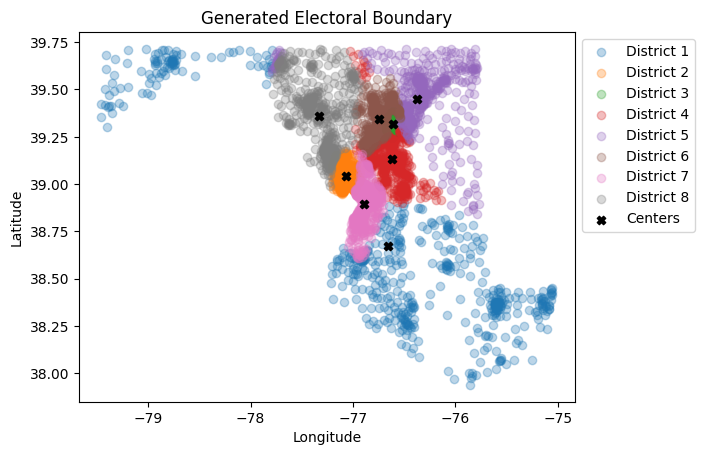

In [ ]:
plotting_map(even_clusters, even_centers)

<h1>Conclusions, Thoughts, Improvements</h1>



The exercise has revealed some interesting insights. While K-means clustering can produce intriguing electoral boundaries, it is not a complete solution on its own. We face a trade-off between equal population distribution, population densities, and logically defined boundaries, the latter of which can be quite subjective. Human judgment can easily assess a boundary as well-defined, but clustering algorithms have limitations in this regard.

Focusing only on the state of Maryland presents its own set of limitations, potentially overlooking issues that may arise in other regions. Additionally, clustering algorithms do not consider geographical attributes such as bodies of water or mountains. Including the exact population of each census district could improve precision, but this would require modifying the current implementations.

Improving the distance penalty implementation hinges on refining the distance equation, balancing practical distance with population size. This balancing act means some data points may be misassigned, and in some cases, the algorithm might not converge.

The Disperse Assignment implementation is computationally intensive, requiring significant time to achieve convergence. Additionally, there is a risk of misassigning data points, although this approach ensures that each cluster is full. A potential improvement could be to relax the size restrictions for each cluster.







Future Directions:

* Incorporating Geographic Data: Future implementations should include
geographical attributes to create more realistic and practical boundaries.
Enhanced Distance Metrics: Refining the distance metrics to better balance practical distance and population size could reduce misassignments and improve convergence rates.

* Flexible Cluster Sizes: Relaxing the strict size constraints on clusters might reduce computational overhead and lead to more efficient algorithms.
Cross-Regional Analysis: Extending the analysis beyond Maryland to include diverse regions could uncover additional challenges and opportunities, leading to more robust solutions.

* Hybrid Approaches: Combining clustering algorithms with human expertise or other algorithms that consider additional factors like socioeconomic data or geographic barriers might yield better results.
